In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from logprogress import *
import matplotlib
matplotlib.rc('font', family='DejaVu Sans')

# Нейронная сеть. Word2vec

В этой работе мы рассмотрим работу нейронной сети на примере формирования 
векторного представления слов русского языка, т.е. реализуем вариант алгоритма 
[word2vec](https://ru.wikipedia.org/wiki/Word2vec).

Алгоритм `word2vec` пытается сопоставить словам какого либо языка
контекст этих слов (и обратно), где под контекстом понимаются
близко расположенные слова.
Контекст записывают в виде вектора, каждая координата которого соответсвует слову в языке,
и значение `1` в координате означает присутствие слова в контексте.
Название алгоритма подсказывает нам, что он преобразует слова в вектора.
Между векторами можно считать расстояние, и оказывается, что близкие в смысле векторов
слова имеют близкое значение, т.е. алгоритму удается выделить смысловую составляющую слов.

Начнем понемногу реализовывать алгоритм, делая по ходу необходимые
замечания.


## Подготовка текста

Начнем с чтения достоточно длинного текста на русском языке, пусть это будет ["Анна Каренина" Л.Н.Толстого](http://az.lib.ru/t/tolstoj_lew_nikolaewich/text_0080.shtml).
В папке с примерами уже находится текст романа в кодировке UTF8.
Мы разбиваем текст в список слов.

In [20]:
import re
import codecs
file = codecs.open('karenina.txt', 'r', encoding='utf-8')
source_str=file.read()
source_words=re.findall('(\w+)|\n\n+|[.?!]', source_str, re.UNICODE)
file.close()
print('Список слов:',source_words[:10])
print('Всего слов, включая концы предложений:',len(source_words))

Список слов: ['Лев', 'Николаевич', 'Толстой', '', 'Анна', 'Каренина', '', 'Мне', 'отмщение', 'и']
Всего слов, включая концы предложений: 294903


Мы убрали всю пунктуацию, но сохранили разбиение на преложения, представив конец предложения в виде пустой строки в нашем списке.
Составим теперь перечень всех слов в списке и посчитаем их частоты.

In [21]:
from collections import Counter
all_words=Counter(source_words)
number_of_sentences=all_words.pop('',None)
print('Всего предложений:',number_of_sentences)
print('Всего различных слов:',len(all_words))
print('Самые часто встречающиеся слова:',all_words.most_common(10))

Всего предложений: 23542
Всего различных слов: 35349
Самые часто встречающиеся слова: [('и', 11972), ('не', 6296), ('что', 5786), ('в', 5380), ('он', 4457), ('на', 3456), ('с', 3282), ('она', 2644), ('его', 2549), ('как', 2352)]


Преобразуем теперь список слов в список предложений.
Если первое слово в предложении встречается где-то в тексте, написанным со строчной буквы, 
то пишем его со строчной буквы.

In [22]:
import itertools
sentences=[list(y) for x, y in itertools.groupby(source_words, lambda z: z == '') if not x]
for sentence in sentences:
    first_word_lower_case=sentence[0].lower()
    if first_word_lower_case in all_words: sentence[0]=first_word_lower_case
print('Начало текста:',sentences[:6])

Начало текста: [['Лев', 'Николаевич', 'Толстой'], ['Анна', 'Каренина'], ['мне', 'отмщение', 'и', 'аз', 'воздам'], ['часть', 'ПЕРВАЯ'], ['I'], ['все', 'счастливые', 'семьи', 'похожи', 'друг', 'на', 'друга', 'каждая', 'несчастливая', 'семья', 'несчастлива', 'по', 'своему']]


Пересчитаем частоты слов с учетом изменившегося регистра.

In [23]:
all_words=Counter([word for sentence in sentences for word in sentence])
number_of_sentences=len(sentences)
print('Всего предложений:',number_of_sentences)
print('Всего различных слов:',len(all_words))
print('Самые часто встречающиеся слова:',all_words.most_common(10))

Всего предложений: 21483
Всего различных слов: 33532
Самые часто встречающиеся слова: [('и', 12906), ('не', 6529), ('что', 6129), ('в', 5719), ('он', 5546), ('на', 3594), ('она', 3432), ('с', 3358), ('я', 3189), ('как', 2678)]


Уберем слова, которые встречаются слишком редко, так как про них мы слишком мало будем знать, чтобы делать выводы.

In [24]:
least_count=50
max_count=10000
common_words={k: v for k, v in all_words.items() if v>=least_count and v<=max_count}
print('Число встречающихся минимум',least_count,"раз слов:",len(common_words))

Число встречающихся минимум 50 раз слов: 560


Сопоставим теперь словам числовые значения: самое частое слово будет иметь значение 1, следующее за ним по частоте значение 2, и т.д.

In [25]:
words_sorted_by_frequency=list(map(lambda x: x[0], sorted(common_words.items(), key=lambda x: -x[1])))
words_codes=dict([(w,c) for c,w in enumerate(words_sorted_by_frequency)])
# эти коллекции можно использовать для сопоставления словам чисел и обратно
print(words_sorted_by_frequency[words_codes['ты']])

ты


Теперь заменим в тексте все слова ни их коды для ускорения дальнейшей работы.
Редкие слова будут просто отброшены из текста.

In [26]:
encoded_text=[[words_codes[word] for word in sentence if word in words_codes] for sentence in sentences]
# убираем пустые предложения меньше заданной длины
minimal_length=4
encoded_text=[sentence for sentence in encoded_text if len(sentence)>=minimal_length]
print('Начало закодированного текста:', encoded_text[:6])
print('Число предложений:', len(encoded_text))

Начало закодированного текста: [[15, 347, 4, 506, 27, 391], [311, 1, 332, 29, 2, 6, 2, 67, 550, 461, 1, 0, 70, 282, 6, 84, 2, 550], [219, 11, 46, 173, 478], [15, 1, 47, 2, 67, 1, 4, 292, 103, 157, 235, 64, 44], [311, 0, 31, 245, 224, 173, 0, 16, 231], [392, 27, 8, 6, 41, 483, 320, 40, 321, 94, 88, 80, 542]]
Число предложений: 14191


Для удобства определим функцию, которая будет преобразовывать закодированный текст в читаемый.

In [27]:
def decode(txt):
    return words_sorted_by_frequency[txt] if isinstance(txt,(int,np.integer)) else list(map(decode, list(txt)))

print('Раскодированное начало:', decode(encoded_text[:6]))

Раскодированное начало: [['все', 'друг', 'на', 'друга', 'по', 'своему'], ['жена', 'что', 'муж', 'был', 'в', 'с', 'в', 'их', 'доме', 'мужу', 'что', 'не', 'может', 'жить', 'с', 'ним', 'в', 'доме'], ['положение', 'это', 'уже', 'день', 'всеми'], ['все', 'что', 'нет', 'в', 'их', 'что', 'на', 'люди', 'более', 'между', 'собой', 'чем', 'они'], ['жена', 'не', 'из', 'своих', 'мужа', 'день', 'не', 'было', 'дома'], ['дети', 'по', 'как', 'с', 'ей', 'новое', 'место', 'еще', 'вчера', 'со', 'во', 'время', 'обеда']]


Наконец создадим функцию, которая будет возвращать случайный контекст из текста.
Максимальное расстояние между словами в контексте передаем в качестве параметра.

In [28]:
def random_context(text, distance_between_words=5):
    random_sentence=text[np.random.randint(0,len(text))]
    word_index=np.random.randint(0,len(random_sentence))
    word=random_sentence[word_index]
    left_context=random_sentence[max(0,word_index-distance_between_words):word_index]
    right_context=random_sentence[(word_index+1):min(len(random_sentence),word_index+distance_between_words)]
    return word, left_context+right_context

print('Случайный контекст:', decode(random_context(encoded_text)))

Случайный контекст: ['ее', ['же', 'на', 'теперь', 'о', 'тех']]


## Нейронная сеть

Для конструирования очень сложной функции $F$ большого числа аргументов, про которую ничего не известно, кроме некоторых значений, можно использовать искуственную нейронную сеть.
Такую нейронную сеть задают как композицию нескольких простых функций, которые зависят от параметров:
$$F(x)=f_{\theta_1}(f_{\theta_2}(\ldots (f_{\theta_N}(x))\ldots))
=f_{\theta_1}\circ f_{\theta_2}\circ \cdots \circ f_{\theta_N}(x).$$
Отдельную функцию $f_{\theta_j}$ называют *слоем* нейронной сети.
Если функций в композиции достаточно много и они достаточно разумно подобраны, то с помощью подбора параметров оказывается возможно приблизить любую функцию достаточно точно.
В качестве меры точности приближения будем использовать функцию $R(x,y)$, которая возвращает ошибку значения $y$ функции с эталонным на данном аргументе $x$.
Т.е. при подборе параметров $\theta$ мы хотим, чтобы $R(x,F(x))$ достигало наименьшего значения в среднем по всем $x$:
$$\theta=\mathrm{argmin}\;E_x[R(x,F(x))].$$
Среднее значение по данному тестовому набору аргументов можно оценить как среднее арифметическое:
$$E_x[f(x)]=\frac 1N\sum_{i=1}^N f(x_i).$$
Для нахождения же минимума ошибки можно воспользоваться градиентным спуском, т.е. имея некоторое начальное приближение для параметров, последовательно улучшать их, делая сдвиги в направлении наибольшего убывания функции, т.е. в направлении антиградиента:
$$\theta_k\mapsto \theta_k-\alpha \frac{\partial}{\partial \theta_k}E_x[R(x,F(x))],$$
здесь параметр $\alpha$ выбирают достаточно большим, чтобы число шагов для нахождения минимума было не слишком большим, однако $\alpha$ должно быть достаточно малым, чтобы ошибка действительно уменьшалась на каждой итерации.
Если мат. ожидание оценивается через среднее арифмитическое, то гардиент превращается в сумму градиентов,
каждый из которых может быть вычислен независимо от остальных:
$$\frac{\partial}{\partial \theta_k}E_x[R(x,F(x))]
=\frac1N\sum_{i=1}^N \frac{\partial}{\partial \theta_k} R(x_i, F(x_i)).$$
При практическом применении градиентного спуска может оказаться, что размер выборки $N$ очень велик (миллиарды элементов и более), так что для ускорения расчетов можно брать для оценки градиента не всю выборку, а только ее часть, причем эта часть каждые несколько итераций должна меняться.
Получившийся таким образом метод называют стохастическим градиентным спуском.

Перейдем к вычислению градиента. 
Обратите внимание, что $\theta_k$ может быть вектором параметров $\theta_k=(\theta_{k,1},\ldots,\theta_{k,N_k})$, 
а не одним числом, поэтому обозначение $\frac{\partial}{\partial\theta_k}$ обозначает также не одно число, а вектор из производных $(\frac{\partial}{\partial\theta_{k,1}},\ldots,\frac{\partial}{\partial\theta_{k,N_k}})$.

Градиент ошибки по цепному правилу: 
$$\frac{\partial}{\partial\theta}R(x,F(x))
=\sum_k \frac{\partial R(x,y)}{\partial y_k}\bigg|_{y=F(x)} \frac{\partial F_k(x)}{\partial \theta}.$$
Таким образом, чтобы найти градиент ошибки по параметрам, нужно уметь вычислять частные производные функции ошибки по результату $y$ вычисления искомой функции и вычислить их с использованием значения функции $y=F(x)$, вычисленной на текущем наборе параметров $\theta$.
Также нужно уметь вычислять градиент самой функции $F$ по параметрам, и вычислить этот градиент на текущих значениях параметров $\theta$.
Так как функция $F$ представлена композицией, то градиент считается последовательным дифференциированием каждой из функций в композиции, так называемым методом обратного распространения (backpropagation).
Искомую функцию представим как $F(x)=f_{\theta_1}(F^{N-1}(x))$, где через $F^{N-1}$ мы обозначили композицию всех функций, составляющих $F$, кроме $f_{\theta_1}$, которую мы выделели явно.
Функция $f_{\theta_1}$ векторнозначная, т.е. $f_{\theta_1}(x)$ - это целый вектор с координатами $f_{\theta_1}(x)=(f_{\theta_1,1}(x),\ldots,f_{\theta_1,M_1}(x))$.
При вычислении градиента вектора нужно заменить каждую координату вектора не градиент этой координаты,
так что дальше мы будем дифференциировать только одну координату $F_k(x)$.
Если мы ищем градиент по $\theta_1$, то дифференциировать можно непосредственно по $\theta_1$ (здесь неявно используется, что $F_{N-1}$ не зависит от параметров $\theta_1$):
$$\frac{\partial F(x)_k}{\partial \theta_1}=\frac{\partial f_{\theta_1,k}}{\partial\theta_1}(F^{N-1}(x)),$$
т.е. чтобы вычислить градиент, нам нужно знать производную $f$ по параметрам $\theta_1$ и вычислить ее в точке $F^{N-1}(x)$.
Если же нам нужен градиент по другим параметрам $\theta_j$, $j\neq 1$, то
снова воспользуемся цепным правилом:
$$\frac{\partial F_k(x)}{\partial \theta_j}
=\frac{\partial f_{\theta_1,k}(F^{N-1}(x))}{\partial \theta_j}
=\sum_i \frac{\partial f_{\theta_1,k}(y)}{\partial y_i}\bigg|_{y=F^{N-1}(x)}
\frac{\partial F^{N-1}_i(x)}{\partial\theta_j}.$$
Теперь производную по параметрам $\theta_i$ нужно считать не от композиции $N$ функций, а только от $N-1$ функции, т.е. мы ввели рекурсию. 
Чтобы найти градиент от всех $F$ по параметрам $\theta_j$, мы сначала должны вычислить все аргументы функций $f_{\theta_i}$ на текущем значении $x$ и параметров, замем последовательно найти 
$\frac{\partial f_{\theta_l,k}(y)}{\partial y_i}$ начиная с $l=1$.
Когда $l=i$, то можно дифференциировать непосредственно $f_{\theta_i}$, дальнейшее применение цепного правила не требуется.
До некой степени метод обратного распространения похож на автоматическое дифференциирование: мы вычисляем значение фнукции и производной для обертывающих функций, с тем чтобы по этим значениям найти значение функции и производных для внетренних функций.
Заметим, что функции $f_{\theta_j}$ могут различаться не только параметрами $\theta_j$, 
но и видом самой функции.

Мы пришли к следующему алгоритму обновления параметров $\theta$ на $\theta'$ для одного шага длины $\alpha$ градентного спуска.

1. Положить $\theta_i'=\theta_i$ для всех $i$.
1. Выбрать один $x$ из выборки.
1. Положить $z_{N+1}=x$.
1. Вычислить $z_j=f_{\theta_j}(z_{j+1})$ для $j=1\ldots N$.
1. Вычислить ошибку $R(x,z_1)$, использовать ее для критерия останова и проверки сходимости.
1. Вычислить градиент $dz_1$: $dz_{1,j}=\frac{\partial R(x,y)}{\partial y_j}\bigg|_{y=z_1}$.
1. Вычислить градиенты $dz_{j+1}$ для $j=1\ldots N-1$:
$$dz_{j+1,i}
=\sum_k\frac{\partial f_{\theta_j,k}(x)}{\partial x_i}\bigg|_{x=z_{j+1}}dz_{j,k}
=\frac{\partial f_{\theta_j}(x)}{\partial x_i}\bigg|_{x=z_{j+1}}\cdot dz_j.
$$
1. Найти поправки $d\theta_j$ к параметрам:
$$d\theta_j=\sum_i \frac{\partial f_{\theta_j,i}(x)}{\partial \theta_j}\bigg|_{x=z_{j+1}}dz_{j,i}
=\frac{\partial f_{\theta_j}(x)}{\partial \theta_j}\bigg|_{x=z_{j+1}}\cdot dz_{j}
.$$
1. Обновить параметры: $\theta_j'\mapsto \theta_j'-\alpha d\theta_j$.
1. Повторить начиная 3-го пункта для следующего $x$ из выборки, пока выборка не исчерпается.
1. Перейти к использованию обновленных параметров $\theta_j\gets\theta_j'$.

Одной из популярных функций потерь $R$ является квадратичная ошибка:
$$R_{sq}(x,y)=\|D(x)-y\|^2,$$
где $D(x)$ - желаемое значение функции $F$, которого мы пытаемся достичь путем тренировки сети.
Градиент квадратичной ошибки легко вычисляется:
$$\frac{\partial R_{sq}(x,y)}{\partial y_k}=D_k(x)-y_k.$$

Если же $F$ возвращает вероятностные распределения, т.е. $F_k(x)\geq 0$, $\sum_k F_k(x)=1$,
то в качестве функции потерь часто рассматривается **[Перекрестная энтропия](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D1%91%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)**:
$$R(x,y)=-\sum_k p_k(x)\ln y_k,$$
где $p_k(x)$ - желаемая вероятность k-го исхода, если на входе сети $x$.
Часто однако точное значение желаемой вероятности неизвестно, так вместо вероятностей тренировочные данные содержат выборку значений случайной величины. 
Пусть аргументу $x$ случайная величиная сопоставила $k_0$, тогда в тренировочные данные войдет вектор $t_k(x)$,
такой что $t_{k_0}(x)=1$ и $t_k(x)=0$ для всех $k_0\neq0$.
Тогда функцию потерь можно выбрать в виде:
$$R_{cr}(x,y)=-\sum_k t_k(x)\ln y_k=-\ln y_{k_0}.$$
Среднее значения $R_{cr}$ совпадает с перекрестной энтропией $p(x)$ и $F(x)$.
Градиент перекрестной энтропии легко найти:
$$\frac{\partial R_{cr}(x,y)}{\partial y_k}=-t_k(x)/y_k.$$

In [29]:
# Фнукции потерь возвращают пару: значение функции, градиент
def loss_function_sq(Dx,y):
    delta=Dx-y
    return np.dot(delta,delta), delta

def loss_function_cr(tx,y):
    return -np.sum(tx*np.log(y)), -tx/y

Рассмотрим теперь функции $f_{\theta}$, которые задают операцию на одном слое.
Простейшая функция, которую можно взять в качестве слоя - это умножение на матрицу,
т.е. $f_{\theta}(x)=\theta x$ или в координатах:
$$f_{\theta,k}(x)=\sum_j \theta_{k,j} x_j.$$
Размер $a\times b$ матрицы $\theta$ определяет длину входа $b$ и длину выхода $a$.
Градиент этой функции тоже считается через умножению на матрицу:
$$dx\cdot\frac{\partial f_{\theta}(x)}{\partial x_k}
=\sum_j dx_j\frac{\partial f_{\theta,j}(x)}{\partial x_k}
=\sum_j dx_j\theta_{j,k}=(dx\,\theta)_k.$$
Аналогично считается градиент по параметрам:
$$dx\cdot\frac{\partial f_{\theta}(x)}{\partial \theta_{k,j}}
=\sum_i dx_i\frac{\partial f_{\theta,i}(x)}{\partial\theta_{k,j}}
=\sum_i dx_i\delta_{k,i}x_j=(dx_k)x_j.$$
Отметим, что иногда полезно добавить к линейным функциям сдвиг, 
т.е. вычислять функции $\theta_{kj}x_j+\phi_k$,
однако этого можно добиться без усложнения теории, добавив к $x$ одну фиктивную координату всегда равную $1$.

In [38]:
def linear_layer(theta, x, optimize=False):
    if optimize:
        print(theta.shape, x.shape)
        i, = np.where(x == 1)
        return theta[:, i[0]]
    return np.dot(theta, x)

def linear_layer_dx(dx, theta):
    return np.dot(dx, theta)

def linear_layer_dtheta(dx, x):
    return dx[:,None]*x[None,:]

Линейные функции просты, позволяют задавать связи между координатами, поэтому они являются основным строительным блоком нейронной сети.
Однако ограничиться использованием только линейных функций нельзя, так как композицией линейных функций можно получить только линейные функции, а мы хотим получать любые функции.
Поэтому к линейным функциям нужно добавить несколько нелинейных функций, называемых функциями [активации](https://en.wikipedia.org/wiki/Activation_function).
Обычно зависимость от параметров включают в слои с линейной функцией, а нелинейные функции берут фиксированными, не зваисящими от параметров.
Одним из популярных функций активации является логистическая функция, применяемая к каждой координате независимо от других:
$$f_{log,k}(x)=\frac1{1+e^{-x_k}}.$$
Градиент логистической функции также считается покоординатно:
$$dx\cdot\frac{\partial f_{log}(x)}{\partial x_k}
=\sum_j dx_j \frac{\partial f_{log,j}(x)}{\partial x_k}
=dx_k\frac{\partial f_{log,k}(x)}{\partial x_k}
=dx_k\frac{e^{-x_k}}{(1+e^{-x_k})^2}.$$

In [39]:
# Функции активации возращают пару: значение функции на аргументе, вспомогательные значения.
# Вспомогательные значения используется позже для ускорения вычисления градинта.
def logistic_function(x):
    t=np.exp(-x)
    return 1/(1+t), t

# Функция для вычисления градиента принимают на вход результат (y,t) вычисления функции активации.
def logistic_function_dx(dx, y, t):
    return dx*t*y*y

Если на выходе нейронной сети требуется получить распределение вероятности, т.е. все координаты должны быть положительны и в сумме давать единицу, то последним слоем сети удобно исползовать softmax, вычисляемый по формулам:
$$f_{softmax,k}(x)=\frac{e^{-x_k}}{\sum_j e^{-x_j}}.$$
Градиент softmax'а можно найти следующим образом:
$$dx\cdot \frac{\partial f_{softmax}(x)}{\partial x_k}
=\sum_i dx_i\frac{\partial f_{softmax,i}(x)}{\partial x_k}
=\sum_i dx_i\left(\frac{e^{-x_k-x_i}}{(\sum_j e^{-x_j})^2}-\frac{\delta_{ki}e^{-x_k}}{\sum_j e^{-x_j}}\right)
=\frac{e^{-x_k}\sum_i e^{-x_i}dx_i}{(\sum_j e^{-x_j})^2}-\frac{e^{-x_k}dx_k}{\sum_j e^{-x_j}}
.$$

In [40]:
def softmax(x):
    t=np.exp(-x)
    return t/np.sum(t)

def softmax_dx(dx,y):
    # y=softmax(x)
    w=y*dx
    return y*np.sum(w)-w

# Восстановление слов по контексту

После долгой подготовки, мы наконец готовы перейти к задаче восстановления контекста для слова.
Решать эту задачу поручим нейронной сети.
Нейронная сеть не работает с дискретным обьектами, поэтому нам нужно сначала закодировать слова в виде векторов.
Эти вектора будут иметь длину, равную числу слов, которым мы присвоили коды.
Слову будет соответствовать вектор, содержащий одну единицу в координате, соответствующей коду слова, все остальные координаты равны нулю.
Нейронная сеть будет возвращать вектор, координаты которого равны вероятностям встретить соответстввющее словов в контексте.
При обучении мы будем использовать контексты, в которых все координаты для отсутствующих слов равны нулю, а остальные координаты равны и в сумме дают 1.

In [41]:
dimensionality=len(words_sorted_by_frequency)

def context_to_vector(context):
    result=np.zeros(dimensionality)
    for word in context: result[word]+=1./len(context)
    return result 

print("Число слов в случайном контексте:", np.sum(0!=context_to_vector(random_context(encoded_text)[1])))


Число слов в случайном контексте: 6


Нейронную сеть рассмотрим одну из самых простейших, состоящую из двух линейных слоев и softmax:
$$F(x)=f_{softmax}(f_B(f_A(x))).$$
Линейные слои можно было бы обьединить в один слой, но мы этого делать не будем, так как матрица $B$ потребуется нам позже.
Матрица $A$ имеет размер $d\times n$, а матрица $B$ имеет размер $n\times d$,
где $n$ - число имеющих коды слов, $d$ - число нейронов в промежуточном слое, которое имеет смысл числа категорий, к которым можно относить слова. 
В качестве функции потерь будем использовать перекрестную энтропию $R_{cr}$.
Используя реализованные выше функции активации и градиенты, реализуем функцию нашей нейронной сети, функцию потерь и ее градиент.

In [44]:
def neural_network(A,B,x):
    return softmax(linear_layer(B, linear_layer(A, x, True)))[0]

def loss(A, B, x, tx, return_grad=True):
    z3=linear_layer(A, x)
    z2=linear_layer(B, z3)
    z1=softmax(z2)
    R,dz1=loss_function_cr(tx, z1)
    if not return_grad: return R
    dz2=softmax_dx(dz1, z1)
    dB=linear_layer_dtheta(dz2, z3)
    dz3=linear_layer_dx(dz2, B)
    dA=linear_layer_dtheta(dz3, x)
    return R, dA, dB    

def grad(A, B, x, tx, return_grad=True):
    z3=linear_layer(A, x, True)
    z2=linear_layer(B, z3)
    z1=softmax(z2)
    R,dz1=loss_function_cr(tx, z1)
    if not return_grad: return R
    dz2=softmax_dx(dz1, z1)
    dz3=linear_layer_dx(dz2, B)
    dx=linear_layer_dx(dz3, A)
    return R, dx

Проверим корректность вычисления градиента, для этого воспользуемся формулой Тейлора:
$$R[A+D_A, B+D_B]-R[A,B]-\epsilon D_A\cdot\frac{\partial R[A,B]}{\partial A}
-\epsilon D_B\cdot\frac{\partial R[A,B]}{\partial B}=O(\epsilon^2).$$
Мы зафиксируем некоторое случайные $A$, $B$, $D_A$, $D_B$, и на малых приращениях $\epsilon$
вычислим левую часть, убедившись, что она убывает как $\epsilon^2$ при уменьшении $\epsilon\to0$.

Wall time: 978 µs


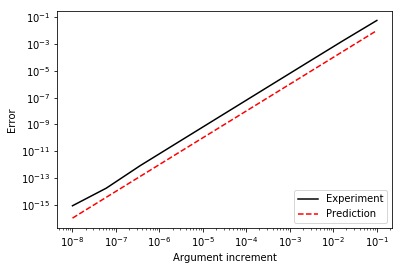

In [45]:
dim=10
x=np.random.rand(dim)
t=np.random.rand(dim)
A=np.random.rand(dim, dim)
B=np.random.rand(dim, dim)
DA=np.random.rand(dim, dim)
DB=np.random.rand(dim, dim)*0
%time R,dA,dB=loss(A,B,x,t)
derror=np.sum(DA*dA)+np.sum(DB*dB)
epsilon=np.logspace(-8,-1,10)
error=np.empty(len(epsilon))
for n in range(len(epsilon)):
    error[n]=loss(A+epsilon[n]*DA,B+epsilon[n]*DB,x,t,return_grad=False)-R-derror*epsilon[n]
plt.loglog(epsilon, np.abs(error), '-k')
plt.loglog(epsilon, epsilon*epsilon, '--r')
plt.xlabel("Argument increment")
plt.ylabel("Error")
plt.legend(['Experiment','Prediction'],loc=4)
plt.show()

Теперь мы можем написать функцию, которая будет тренировать нейронную сеть,
т.е. будет оптимизировать веса $A$ и $B$ так, чтобы ошибка $R$ минимизировалась.
Считать ошибку $R$ сразу по всем словам и контекстам непрактично, так как займет много времени.
Вместо этого мы будем генерировать небольшую группу `batch` тестовых наборов
и будем делать несколько шагов градиентного спуска для этой группы,
затем генерируем новый набор и повторяем.

In [47]:
def make_batch(text, size=300):
    C=[]; W=[]
    for _ in range(size):
        word, context=random_context(text)
        W.append(context_to_vector([word]))
        C.append(context_to_vector(context))
    return W, C

def train_on_batch(A, B, batch, number_of_steps=3, step_size=5):
    batch_size=len(batch[0])
    history=[]
    for _ in range(number_of_steps):
        dA=np.zeros(A.shape); dB=np.zeros(B.shape); 
        error=0
        for W,C in zip(*batch):
            R,DA,DB=loss(A,B,W,C)
            error+=R; dA+=DA; dB+=DB
        A-=step_size/batch_size*dA
        B-=step_size/batch_size*dB
        history.append(error/batch_size)
    return history

def train_network(A, B, text, test=None, number_of_steps=1000, debug=False):
    report_each=number_of_steps/10
    history=[]
    if not test is None: 
        print("Initial error {}".format(test_network(A, B, test_text)))
    try:
        for n in log_progress(range(1,number_of_steps+1),name='Batch'):
            error=train_on_batch(A, B, make_batch(text))
            if debug: print(n,":",error[-1])
            if not test is None and n%report_each==0: 
                print("Epoch {}, generalization error {}".format(n, test_network(A, B, test_text)))
            history.extend(error)
    except KeyboardInterrupt:
        pass
    return history

def test_network(A, B, text, number_of_samples=1000):
    error=0
    for _ in range(number_of_samples):
        word, context=random_context(text)
        W=context_to_vector([word])
        C=context_to_vector(context)
        error+=loss(A,B,W,C,return_grad=False)
    return error/number_of_samples

Для проверки качества обучения нейронной сети используется тестовый набор
слов и контекстов, отличный от тренировочного набора, используемого для обучения.
Это позволяет проверить, смогла ли сеть выявить существенные характеристики исходных данных,
или только заучила все данные.
Мы разделим весь наш текст на две части, на первой мы будем тренировать сеть, на второй проверять, насколько она хорошо может делать обобщения.

In [48]:
ratio=0.9
train_text=encoded_text[:int(ratio*len(encoded_text))]
test_text=encoded_text[int(ratio*len(encoded_text)):]
features=50
A=np.random.rand(features,dimensionality)
B=np.random.rand(dimensionality,features)

Initial error 6.735565949126008


Epoch 100, generalization error 5.352595603816634
Epoch 200, generalization error 5.348186205849292
Epoch 300, generalization error 5.3313426962276464
Epoch 400, generalization error 5.3032856867888105
Epoch 500, generalization error 5.285963843849475
Epoch 600, generalization error 5.28290482379328
Epoch 700, generalization error 5.281392627590046
Epoch 800, generalization error 5.289993414627068
Epoch 900, generalization error 5.242774349207342
Epoch 1000, generalization error 5.289546825063758
Wall time: 4min 49s


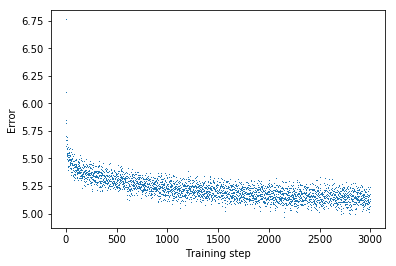

In [49]:
%time history=train_network(A, B, train_text, test=test_text)
plt.plot(history,',')
plt.xlabel("Training step")
plt.ylabel("Error")
plt.show()

## Вектора слов и смысл

Нейронная сеть была нужна нам как вспомогательное средство для нахождения векторного представления слов.
На самом деле нас интересуют веса $B$ нейронной сети, наденные в процессе обучения.
Строка $B[n,:]$ матрицы весов хранит связь слова с кодом $n$ с категориями слов,
вектор $B[n,:]$ и будем называть векторным представлением слова $n$.
Если два слова употребляются в одинаковом контексте, то следует ожидать, что их векторные представления почти совпадают.
Определим функцию, которая будет по матрице $B$ считать расстояние до других слов, и будет возвращать список слов в порядке уменьшеная похожести.

In [50]:
def word2vec(B, n):
    return B[n,:]

def similar_words(B, vec):
    dist=np.sum((B-vec[None,:])**2, axis=1)
    return sorted(enumerate(dist), key=lambda x: x[1])

def distance_matrix(B):
    return np.sum((B[:,:,None]-B[:,None,:])**2, axis=0)

Поищем похожие слова.

In [51]:
print(words_sorted_by_frequency)

['не', 'что', 'в', 'он', 'на', 'она', 'с', 'я', 'как', 'его', 'но', 'это', 'то', 'к', 'ее', 'все', 'было', 'так', 'сказал', 'а', 'же', 'ему', 'о', 'за', 'Левин', 'только', 'ты', 'по', 'у', 'был', 'когда', 'из', 'сказала', 'для', 'бы', 'теперь', 'от', 'да', 'вы', 'была', 'еще', 'ей', 'мне', 'Кити', 'они', 'него', 'уже', 'нет', 'очень', 'быть', 'меня', 'чтобы', 'Вронский', 'этого', 'себя', 'Анна', 'себе', 'были', 'ни', 'если', 'ничего', 'того', 'ну', 'том', 'чем', 'ней', 'Алексей', 'их', 'Степан', 'Аркадьич', 'может', 'Александрович', 'вот', 'есть', 'тем', 'надо', 'ли', 'опять', 'или', 'потому', 'время', 'мог', 'говорил', 'будет', 'ним', 'нее', 'мы', 'до', 'во', 'руку', 'Долли', 'эти', 'которые', 'всегда', 'со', 'этом', 'раз', 'лицо', 'сказать', 'этот', 'вас', 'дело', 'Левина', 'более', 'вдруг', 'свою', 'после', 'который', 'при', 'больше', 'своей', 'без', 'знал', 'где', 'никогда', 'потом', 'жизни', 'говорить', 'хорошо', 'знаю', 'которое', 'об', 'даже', 'пред', 'хотел', 'тебя', 'Сергей', 

In [52]:
def show_similar(B, vec, count=10):
    for code,freq in similar_words(B, vec)[:count]:
        print("{}/{}".format(decode(code),int(freq)),end=" ")

words_to_compare=['Анна','Степан','давно','много','руки']
for word in words_to_compare:
    print(word,":",end=" ")
    show_similar(B, word2vec(B, words_codes[word]))
    print()

Анна : Анна/0 Долли/2 Кити/3 эту/4 княгиня/4 она/5 Бетси/5 сама/5 ее/5 жена/5 
Степан : Степан/0 Аркадьич/7 вышел/8 сел/8 весело/8 разумеется/8 человек/8 проговорил/9 место/9 иметь/9 
давно : давно/0 теперь/4 люблю/5 когда/5 детей/5 зная/5 свое/5 знает/5 бог/5 решительно/5 
много : много/0 та/4 новое/4 всех/4 Анны/4 вообще/4 напротив/4 нынче/4 слишком/4 людей/4 
руки : руки/0 своего/3 вдруг/4 увидав/4 ту/4 дверь/4 глаза/4 которой/4 свое/4 опять/4 


In [53]:
# Попробуем проанализировать отношения слов
def show_relative(n1,n2,n3):
    w1=words_codes[n1]; v1=word2vec(B, w1)
    w2=words_codes[n2]; v2=word2vec(B, w2)
    w3=words_codes[n3]; v3=word2vec(B, w3)
    v4=v2-v1+v3
    print("Как '{}' относится к '{}', также к '{}' относятся следующие слова в порядке убывания уверенности:".format(decode(w1),decode(w2),decode(w3)))
    show_similar(B, v4)
    print("\n")

show_relative('Анна','Степан','она')
show_relative('Степан','Анна','он')

Как 'Анна' относится к 'Степан', также к 'она' относятся следующие слова в порядке убывания уверенности:
Степан/5 он/10 Аркадьич/11 которого/11 человек/12 иметь/12 сел/12 еще/12 вышел/13 Вронский/13 

Как 'Степан' относится к 'Анна', также к 'он' относятся следующие слова в порядке убывания уверенности:
Анна/9 она/10 Кити/10 ее/10 его/11 от/11 сама/12 ней/13 эту/13 Долли/13 



Как мы видим, сеть оказалась в состоянии понять некоторые взаимосвязи между словами, по крайней мере она догадывается, кто имеет какой пол.
Чтобы получить более точные результаты, сеть должна понимать большее число слов (десятки и сотни тысяч), тренероватбся на значительно большей выборке, и иметь более 300 категорий в скрытом слое сети.

Далее мы визуализируем то, что выучила сеть.
Следующая матрица содержит в столбцах разные слова, а каждая строка соответствует какой-то категории.
Т.е. матрица показывает, насколько каждая категория связана с каждым словом.
Если какие-то столбцы похожи, то они соответствуют близким по употреблению словам.

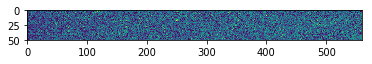

In [54]:
# Выведем все вектора слов
plt.imshow(np.abs(B.T), interpolation='none')
plt.show()

Человеку тяжело найти в этом хаосе похожие столбцы, поэтому мы построим другую матрицу, которая будем содержать расстояние между каждой парой слов.
Синий цвет соответствует близким словам, красный - дальним.

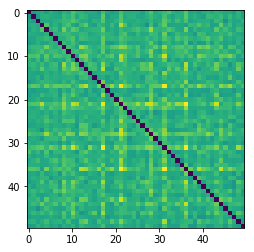

In [55]:
# Выведем матрицу расстояний между словами
plt.imshow(distance_matrix(B), interpolation='none')
plt.show()

По рисунку видно, что слова образуют группы похожих слов.
Чтобы сделать это вывод еще более явным, 
постром график, на котором каждое слово будет представлено точкой,
а положение точки будет зависить от выраженности двух фиксированных понятий.

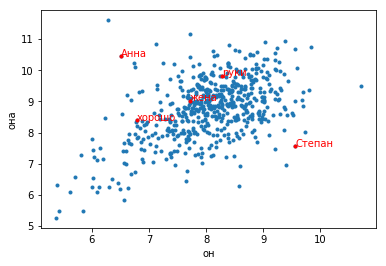

In [56]:
n1='он'; n2='она'
ns=['Анна','Степан','жена','хорошо','руки']
w1=words_codes[n1]; w2=words_codes[n2];
v1=word2vec(B, w1); v2=word2vec(B, w2); 
p1=np.dot(B, v1); p2=np.dot(B, v2); 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(p1,p2,'.')
for n in ns:
    w=words_codes[n]
    ax.plot(p1[w],p2[w],'.r')
    ax.annotate(n, xy=(p1[w],p2[w]),color='r')
plt.xlabel(n1); plt.ylabel(n2);
plt.show()

Так как у нас нет нелинейной функции активации между двумя линейными слоями, то мы имеем линейную комбинацию линейных комбинаций, что, как известно, линейная комбинация, а значит наша нейронная сеть на деле не двухслойная, а однослойная. Добавление функции активации между слоями позволит находить более сложные закономерности, а значит мы будем четче выделять признаки. 